In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.notebook_display import *
from util.numeric_ops import *
from util.tf_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Collect an ensemble of data

In [18]:
img_collections = get_processed_moving_box()
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'images:': 'triangle', 'dim': (50, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical', 'dim': (56, 32, 32)}
{'images:': 'circle-diagnal', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'trangle-horizontal', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'moving box uniform', 'dim': (14, 32, 32)}
{'images:': 'circle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'circle-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical', 'dim': (56, 32, 32)}


In [19]:
train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])

In [20]:
def sample(batch_size = 8, train=True, gap = 1):
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs

In [21]:
def sample_train(batch_size = 8, gap = 1):
    return sample(batch_size)
def sample_dev(batch_size = 8, gap = 1):
    return sample(batch_size, False, gap)

## Take a look at input data

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


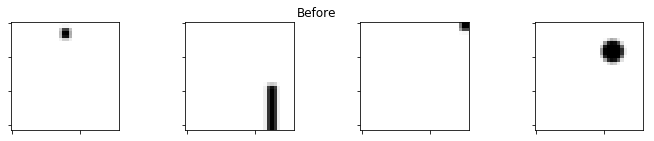

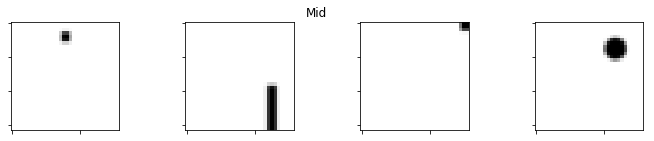

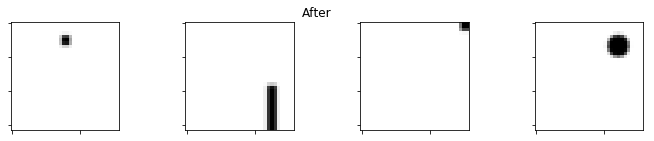

In [22]:
(test_before, test_after), test_mid = sample_train(4)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


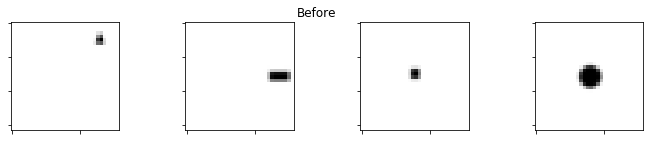

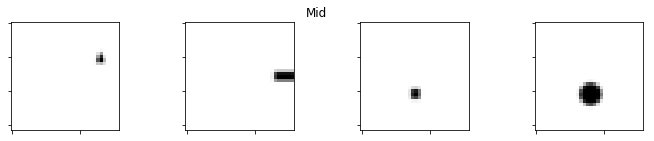

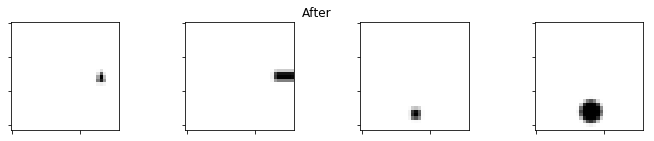

In [23]:
(test_before, test_after), test_mid = sample_dev(4, 11)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

In [24]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)


def gan_loss(logits_real, logits_fake):
    G_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake), logits = logits_fake)
    
    D_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real), logits = logits_real)\
     +  tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake), logits = logits_fake)
        
    G_loss = tf.reduce_mean(G_loss)
    D_loss = tf.reduce_mean(D_loss)
    return D_loss, G_loss

In [178]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator") as scope:
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)], axis=3)
        
        x = tf.layers.conv2d(x, filters = 8, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x,  axis=3, training=is_training)
        
        img = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        img = tf.reshape(img, [-1, 32, 32, 1])
        return img

In [179]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [180]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    return gen_batch, loss

### Model Param

In [181]:
gap = 1
batch_size = 32

learning_rate = 1e-4
beta = 0.9
num_iteration = 4000
relu_alpha = 0.01

In [182]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [ ]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        _, G_loss_curr = sess.run([G_train_step, G_loss], dic)
        
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test = sess.run(G_batch, feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
    return g_losses

## Train !

Iteration 0:  G_loss = 199.47755432128906


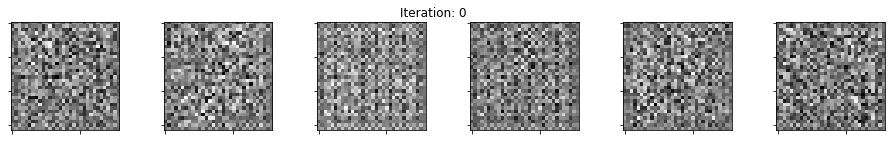

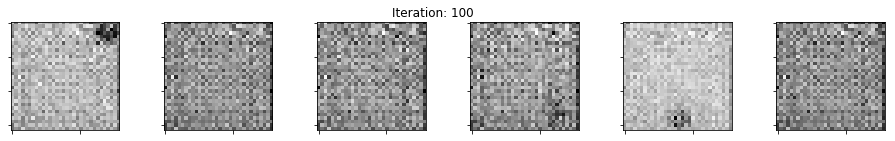

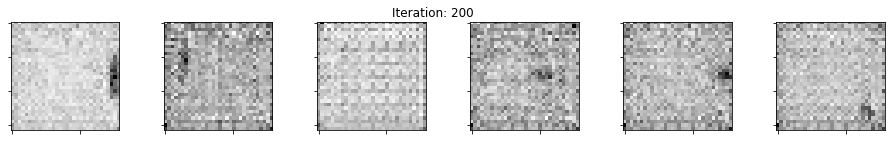

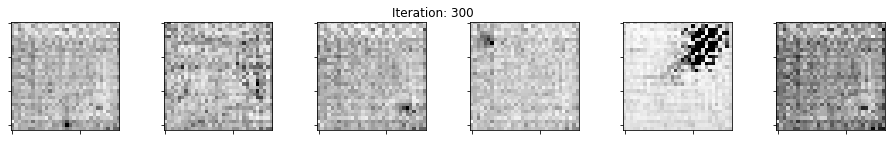

Iteration 400:  G_loss = 32.83588790893555


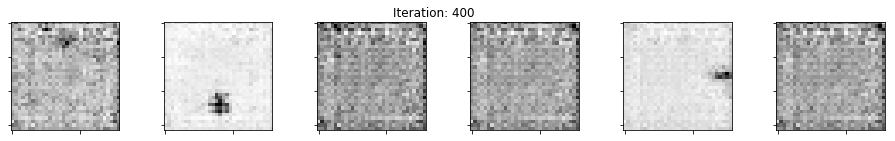

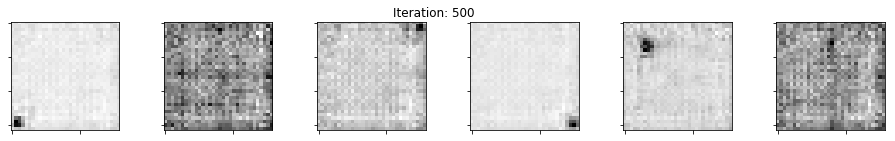

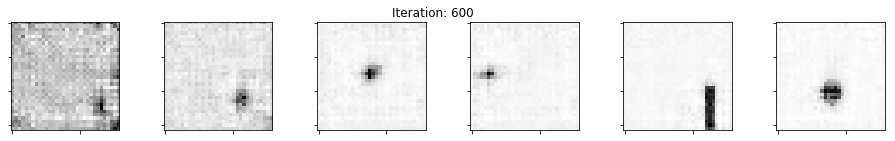

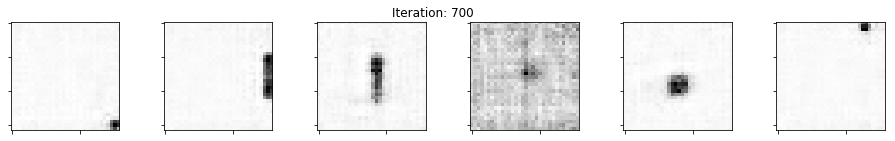

Iteration 800:  G_loss = 9.25815200805664


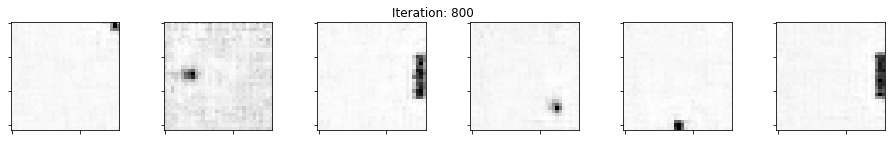

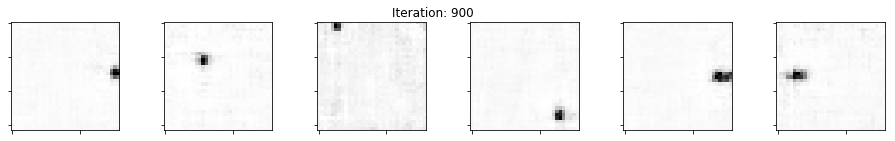

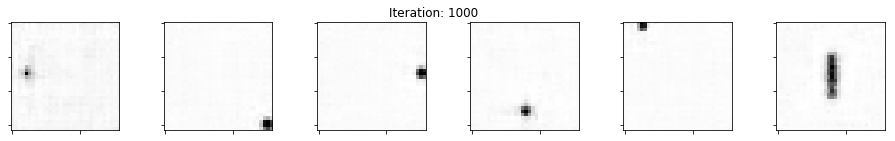

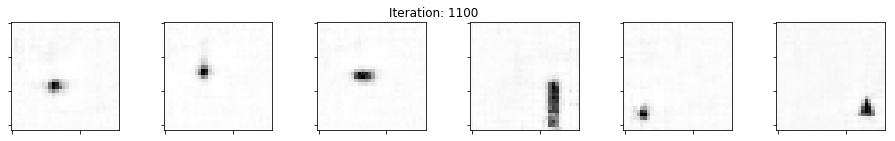

Iteration 1200:  G_loss = 6.630129814147949


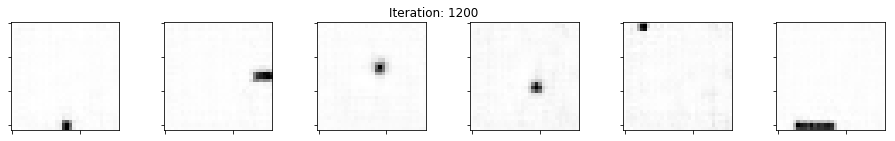

In [ ]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 100)

In [ ]:
figsize = (20, 8)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

In [ ]:
def test_seen(num=4, gap = 3):
    (real_before, real_after), real_mid = sample_train(num, gap)
    gen_batch, loss = get_generattion(real_before, real_after, real_mid)
    print("Loss = {}".format(loss))
    size = (16, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")

In [ ]:
test_seen()

## Validation Loss

In [ ]:
def test_unseens(num = 4, gap = 1, num_test = 1000):
    """
    randomely sample and test generator
    """
    (real_before, real_after), real_mid = sample_dev(num, gap)
    dic = {batch_before: real_before, batch_after: real_after, batch_mid: real_mid, is_training: False}
    gen_batch, _ = sess.run([G_batch, G_loss], dic)
    
    size = (16, 2)
    plot_images(real_before, size, "Before")
    plot_images(real_after, size, "After")
    plot_images(real_mid, size, "Mid - Real")
    plot_images(gen_batch, size, "Mid - Generated")
    
    loss = np.mean([get_generattion(test_before, test_after, test_mid)[1] for _ in range(num_test)])
    print("Validation Loss = {}".format(loss))

In [ ]:
test_unseens(num = 8, gap = 1)

## Test a total difference dataset

In [ ]:
def sample_imgs(imgs, gap = 1, batch_size = 8):
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

In [ ]:
test_imgs = load_imgs("data/moving-box/test/rectangle-32x32.npz")

In [ ]:
(test_before, test_after), test_mid = sample_imgs(test_imgs, gap = 1)
num_test = 1000
gen_batch, _ = get_generattion(test_before, test_after, test_mid)

size = (16, 2)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid-Real")
plot_images(gen_batch, size, "Mid-Generated")


loss = np.mean([get_generattion(test_before, test_after, test_mid)[1] for _ in range(num_test)])
print("Test Loss = {}".format(loss))